In [1]:
import json
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

from rascal.calibrator import Calibrator
from rascal.util import refine_peaks

%matplotlib inline

/Users/marcolam/git/rascal/rascal/calibrator.py:21: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In this example, we'll calibrate a spectrum from the DEep Imaging Multi-Object Spectrograph (DEIMOS) instrument on Keck. We load an example calibration spectrum from the `pypeit` library. (This requires the installation of the latest version on github as of 6 April 2020: pip3 install git+https://github.com/pypeit/PypeIt.git):

In [2]:
spectrum_json = json.load(open('data_keck_deimos/keck_deimos_830g_l_PYPIT.json'))

This spectrum is from the 830G grating and contains Ne, Ar, Kr arc lines.

In [3]:
spectrum = np.array(spectrum_json['spec'])

peaks, _ = find_peaks(spectrum, prominence=1000, distance=20)
peaks_refined = refine_peaks(spectrum, peaks, window_width=3)

As this is a reference template, it also has the wavelengths per pixel which we can use to check our calibration solution.

We'll use this as a hint for the spectral range of the instrument (setting the min/max range). To present a more fair scenario, we pick an approximate min/max and set a tolerance of 500A.

As usual we tell rascal the number of pixels on the detector, a fit tolerance appropriate to the instrument (in this case, we set a slightly lower fit tolerance.

INFO:rascal.calibrator:num_pix is set to 4096.
INFO:rascal.calibrator:pixel_list is set to None.
INFO:rascal.calibrator:Plotting with matplotlib.


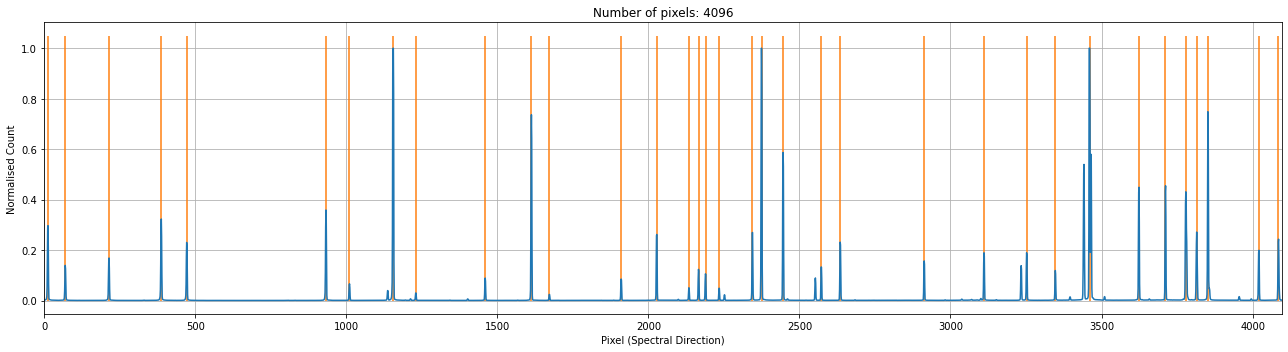

In [4]:
c = Calibrator(peaks_refined, spectrum)

c.set_calibrator_properties(num_pix=len(spectrum),
                            plotting_library='matplotlib',
                            log_level='info') 

c.plot_arc()

In [5]:
c.set_hough_properties(num_slopes=10000,
                       xbins=200,
                       ybins=200,
                       min_wavelength=6500.,
                       max_wavelength=10400.,
                       range_tolerance=500.,
                       linearity_tolerance=50)
c.add_atlas(["He", "Ar", "Kr"], min_intensity=5)

c.set_ransac_properties(sample_size=5,
                        top_n_candidate=5,
                        linear=True,
                        filter_close=True,
                        ransac_thresh=5,
                        candidate_weighted=True,
                        hough_weight=1.0)
c.do_hough_transform()

INFO:rascal.calibrator:Peak at: 6056.061035176943 A
INFO:rascal.calibrator:- matched to 6056.06103515625 A
INFO:rascal.calibrator:Peak at: 6238.431590766122 A
INFO:rascal.calibrator:Peak at: 6538.037109447517 A
INFO:rascal.calibrator:- matched to 6538.037109375 A
INFO:rascal.calibrator:Peak at: 6699.151855409855 A
INFO:rascal.calibrator:- matched to 6699.15185546875 A
INFO:rascal.calibrator:Peak at: 6740.020019474343 A
INFO:rascal.calibrator:- matched to 6740.02001953125 A
INFO:rascal.calibrator:Peak at: 7329.713864962814 A
INFO:rascal.calibrator:Peak at: 7601.4516601860105 A
INFO:rascal.calibrator:- matched to 7601.45166015625 A
INFO:rascal.calibrator:Peak at: 8329.116041345402 A
INFO:rascal.calibrator:Peak at: 8840.01123879077 A
INFO:rascal.calibrator:Peak at: 11087.64638908914 A
INFO:rascal.calibrator:Peak at: 13254.852125905622 A
INFO:rascal.calibrator:Peak at: 14263.40413846747 A
INFO:rascal.calibrator:Peak at: 19320.634892848153 A
INFO:rascal.calibrator:Peak at: 22480.44386826508

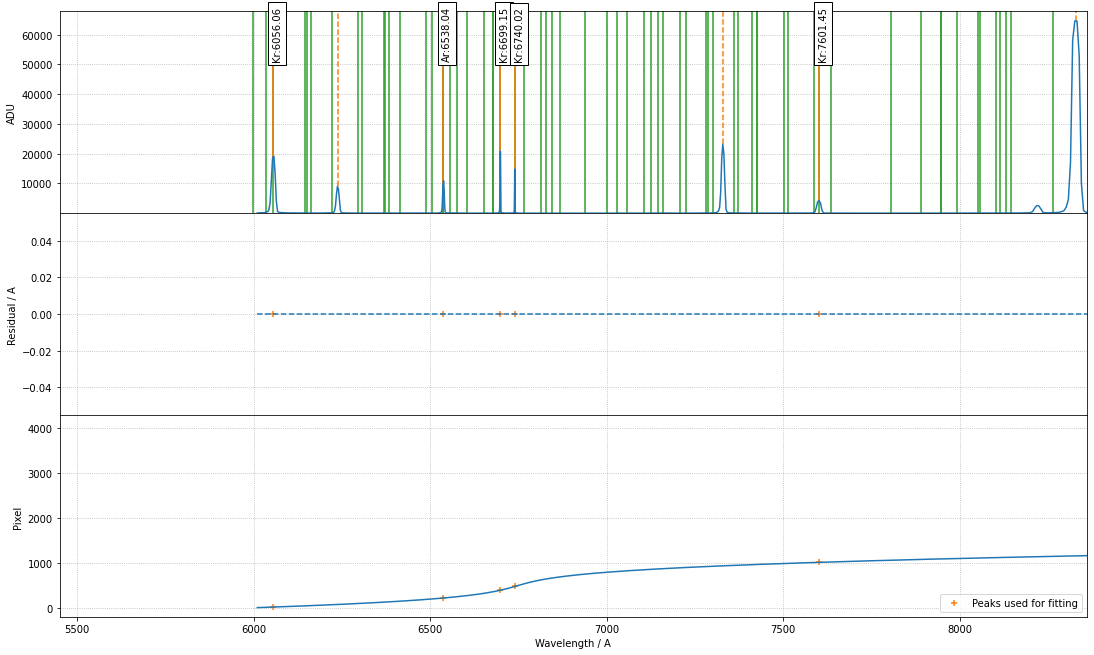

Stdev error: 1.9447575746744097e-08 A
Peaks utilisation rate: 20.0%


In [6]:
best_p, rms, residual, peak_utilisation = c.fit(max_tries=5000)

c.plot_fit(best_p, plot_atlas=True, log_spectrum=False, tolerance=5.0, renderer='notebook')


rms = np.sqrt(np.sum(residual**2 / len(residual)))

print("Stdev error: {} A".format(np.abs(residual).std()))
print("Peaks utilisation rate: {}%".format(peak_utilisation*100))

In [ ]:
c.plot_search_space()